<h2><center> Decision Trees </center></h2>

The main goal of this notebook is to see the differences between a single decision tree, bagging decision tree ensemble, random forest and boosting by using the scikit-learn library

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import fetch_california_housing as cal 

data = cal(as_frame=True)
X = data['data']
y = data['target']

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [3]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [4]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.30)

In [10]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

dt = DecisionTreeRegressor()

In [9]:
import numpy as np
from scipy import stats
import random

eps = 1e-5

random.seed(5)
np.random.seed(5)

class DecisionTree:
    def __init__(self, max_depth=3, criterion='entropy', max_features=None, feature_labels=None, i=0):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes
        self.max_features = max_features
        self.chosen_cols = []
        self.criterion = criterion
        if self.criterion != 'entropy' and self.criterion != 'gini':
            raise Exception('Criterion can be either gini or entropy')

        self.i = max_depth

    def information_gain(self, X, y, thresh):
        idx0 = np.where(X < thresh)
        idx1 = np.where(X > thresh)
        y_0 = y[idx0]
        y_1 = y[idx1]
        if self.criterion == 'entropy':
            value_before = DecisionTree.entropy(y)
            value_after = (len(y_0) * DecisionTree.entropy(y_0) + len(y_1) * DecisionTree.entropy(y_1)) / (
                    len(y_0) + len(y_1))
        else:
            value_before = DecisionTree.gini_impurity(y)
            value_after = (len(y_0) * DecisionTree.gini_impurity(y_0) + len(y_1) * DecisionTree.gini_impurity(y_1)) / (
                    len(y_0) + len(y_1))
        gain = value_before - value_after
        return gain

    @staticmethod
    def entropy(y):
        vals, counts = np.unique(y, return_counts=True)
        return stats.entropy(counts, base=2)

    @staticmethod
    def gini_impurity(y):
        vals, counts = np.unique(y, return_counts=True)
        summed = 0
        total = sum(counts)
        for i in counts:
            prob = (i / total) ** 2
            summed += prob
        return 1 - summed

    @staticmethod
    def split_test(X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def choose_columns(self, ncols):
        if self.max_features == 'sqrt':
            self.max_features = int(np.sqrt(ncols))
        elif type(self.max_features) == str:
            raise ValueError('max_features can be either "sqrt" or an integer between 1 and number of columns')
        elif self.max_features > ncols:
            raise ValueError('max_features cannot exceed number of total columns')
        elif self.max_features < 1:
            raise ValueError('max_features cannot be less than 1')
        column_idx = np.arange(ncols)
        self.chosen_cols = np.random.choice(column_idx, size=self.max_features, replace=False)

    def fit(self, X, y):
        assert type(X) == np.ndarray, 'Given data must be np.ndarray'
        assert type(y) == np.ndarray, 'Given data must be np.ndarray'

        if self.max_depth > 0:
            if self.max_features is not None:
                self.choose_columns(ncols=X.shape[1])
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits.
            thresh = np.array([
                np.linspace(np.min(X[:, i]) + eps, np.max(X[:, i]) - eps, num=10)
                for i in range(X.shape[1])
            ])
            for i in range(X.shape[1]):
                if len(self.chosen_cols) > 0:
                    if i not in self.chosen_cols:
                        gains.append([-1] * 10)
                    else:
                        gains.append([self.information_gain(X[:, i], y, t) for t in thresh[i, :]])
                else:
                    gains.append([self.information_gain(X[:, i], y, t) for t in thresh[i, :]])

            gains = np.nan_to_num(np.array(gains))
            self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
            self.thresh = thresh[self.split_idx, thresh_idx]
            X0, y0, X1, y1 = self.split(X, y, idx=self.split_idx, thresh=self.thresh)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1,
                    criterion=self.criterion,
                    max_features=self.max_features,
                    feature_labels=self.features)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1,
                    criterion=self.criterion,
                    max_features=self.max_features,
                    feature_labels=self.features)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self

    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat


class RandomForest:
    def __init__(self, num_trees=100, max_features='sqrt',
                 bootstrap=True, bootstrap_size=None, params={}):
        self.num_trees = num_trees
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.bootstrap_size = bootstrap_size

        if self.bootstrap_size:
            if not 0 < self.bootstrap_size < 1:
                raise ValueError(
                    'bootstrap_size must be between 0 and 1, indicating the bootstrap sample ratio')
        self.params = params
        self.trees = [
            DecisionTree(
                max_features=self.max_features, **params)
            for i in range(self.num_trees)
        ]

    def generate_idx(self, X):
        indexes = []
        for i in range(self.num_trees):
            if self.bootstrap_size:
                sample_size = int(self.bootstrap_size * X.shape[0])
                idx = np.random.choice(X.shape[0], sample_size, replace=True)
            else:
                idx = np.random.choice(X.shape[0], X.shape[0], replace=True)
            indexes.append(idx)
        return indexes

    def generate_samples(self, X, y):
        indexes = self.generate_idx(X)
        training = [X[idx, :] for idx in indexes]
        labels = [y[idx] for idx in indexes]
        return training, labels

    @staticmethod
    def voting(predictions):
        majority_vote = []
        for i in range(predictions.shape[1]):
            sum_votes = sum(predictions[:, i])
            if (sum_votes / predictions.shape[0]) >= 0.5:
                majority_vote.append(1)
            else:
                majority_vote.append(0)
        return majority_vote

    def fit(self, X, y):
        if self.bootstrap:
            x_samples, y_samples = self.generate_samples(X, y)
        else:
            x_samples = [X for _ in range(self.num_trees)]
            y_samples = [y for _ in range(self.num_trees)]

        for i in range(self.num_trees):
            self.trees[i].fit(x_samples[i], y_samples[i])

    def predict(self, X):
        predictions = []
        for i in range(self.num_trees):
            pred = self.trees[i].predict(X)
            predictions.append(pred)
        predictions = np.array(predictions)
        majority_vote = RandomForest.voting(predictions)
        return majority_vote


In [7]:
def evaluate(model, display=True, provide=False):
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    train_error = mean_squared_error(y_train, train_pred)
    train_error = np.round(np.sqrt(train_error), 3)
    
    test_pred = model.predict(X_test)
    test_error = mean_squared_error(y_test, test_pred)
    test_error = np.round(np.sqrt(test_error), 3)
    
    if display:
        print('Training RMSE: {}'.format(train_error))
        print('Test RMSE: {}'.format(test_error))    
    
    if provide:
        return train_error, test_error

### Decision Tree Bagging

In [8]:
%%time
model1 = BaggingRegressor(base_estimator=dt, 
                         n_estimators=100,
                         max_samples=0.7,
                         oob_score=True,
                         random_state=5)
evaluate(model1)

Training RMSE: 0.253
Test RMSE: 0.519
Wall time: 9.32 s


In [9]:
%%time
model1 = BaggingRegressor(base_estimator=dt, 
                         n_estimators=100,
                         max_samples=0.7,
                         oob_score=True,
                         random_state=5, 
                         n_jobs=-1)
evaluate(model1)

Training RMSE: 0.253
Test RMSE: 0.519
Wall time: 6.62 s


In [10]:
model1.oob_score_

0.8048511603322572

#### Note:

- Using n_jobs parameter dramatically decreases the run time of the algorithm. Setting n_jobs equal to -1 means that all cores are being utilized to run jobs in parallel.

### A single Decision Tree

In [8]:
evaluate(dt)

Training RMSE: 0.0
Test RMSE: 0.72


In [12]:
params = {'max_depth': 10, 'criterion': 'gini'}
ab = RandomForest(max_features=3. )
ab.fit(X_train.to_numpy(), y_train.to_numpy())

In [14]:
pred_y = ab.predict(X_test.to_numpy())
np.sqrt(mean_squared_error(y_test, pred_y))

2.482668078063955

 - As it can be observed from the metrics above, a single fully grown decision tree suffers from overfitting.

### Random Forest

- A random forest with below settings is the same as Bagging Regressor above.

In [12]:
forest = RandomForestRegressor(n_estimators=100, 
                              oob_score=True,
                              max_features=None,
                              max_samples=0.7,
                              random_state=5,
                              n_jobs=-1)
evaluate(forest)

Training RMSE: 0.253
Test RMSE: 0.519


In [13]:
forest.oob_score_

0.8047101645024342

A random forest algorithm with different paramater values

In [14]:
hyperparams = np.arange(1,9,1)

train_errors = []
test_errors = []
for i in hyperparams:
    forest = RandomForestRegressor(n_estimators=100, 
                                  max_depth=20,
                                  max_features=i,
                                  oob_score=True,
                                  random_state=5,
                                  n_jobs=-1)
    train, test = evaluate(forest, display=False, provide=True)
    train_errors.append(train)
    test_errors.append(test)

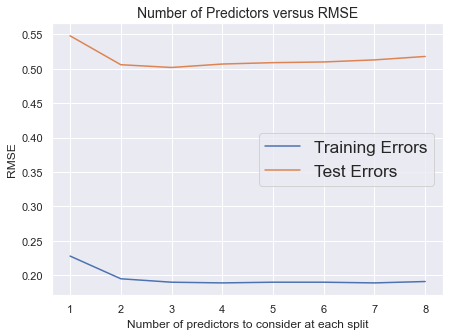

In [15]:
plt.figure(figsize=(7,5))
plt.plot(hyperparams, train_errors, label='Training Errors')
plt.plot(hyperparams, test_errors, label='Test Errors')
plt.legend(fontsize='x-large')
plt.xlabel('Number of predictors to consider at each split', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Number of Predictors versus RMSE', fontsize=14)
plt.show();

In [38]:
forest = RandomForestRegressor(n_estimators=100, 
                              max_depth=20,
                              max_features=3,
                              oob_score=True,
                              random_state=5,
                              n_jobs=-1)
evaluate(forest)

Training RMSE: 0.19
Test RMSE: 0.502


In [17]:
forest.feature_importances_

array([0.40434688, 0.05354708, 0.09307806, 0.03899797, 0.03090169,
       0.12594902, 0.13101519, 0.12216412])

In [18]:
forest.oob_score_

0.8158274174985554

##### Note:

 - Ensemble methods such as Bagging and Random Forest, most of the time, performs better than the single decision tree because they reduce high variance of a single decision tree by combining a certain amount of decision trees. Consequenty, ensemble models do not suffer from overfitting as a single decision tree predictor would. 


 -  Random forest performed better than the bagging algorithm because in bagging algorithm, the produced trees from the bootstrap samples are correlated. This happens because, most of the time, or always, every estimator tree in bagging model will chose the most important predictor as a splitting criteria on the top node; and, therefore, all estimator trees will be similar to each other. However, this is not an issue in Random Forest since only a subset of predictors are considered at each split. Number of predictors to consider at each split is determined by the 'max_features' parameter in the random forest algorithm.
 
 
 - Usually, we set max_features = $\sqrt{d}$, where d is the number of dimensions/predictors. Although, as usual, cross-validation should be preferable for choosing the max_features.

#### Out-Of-Bag Observations (OOB)

- Some of the bootstrapped samples does not include the observation i from the sample space because we sample with replacement.


- The idea is to use corresponding decision trees of those samples to predict i and then take an average (regression) or the majority vote (classification) of those predictions to have an overall prediction of the observation i.


- We do this for every observation i in the sample space to obtain a overall OOB RMSE (regression) or OOB error rate (classification).


- This technique is more desirable when cross-validation is computationally infeasible.


- As it can be seen above, OOB method is a parameter in scikit-learn's bagging and random forest implementation. We need to emphasize **oob_score = True** to use the technique.

In [19]:
hyperparams = np.arange(1,150,10)

oobs = []
for i in hyperparams:
    forest = RandomForestRegressor(n_estimators=i, 
                                  max_depth=20,
                                  max_features=3,
                                  oob_score=True,
                                  random_state=5,
                                  n_jobs=-1)
    forest.fit(X_train, y_train)
    oobs.append(forest.oob_score_)

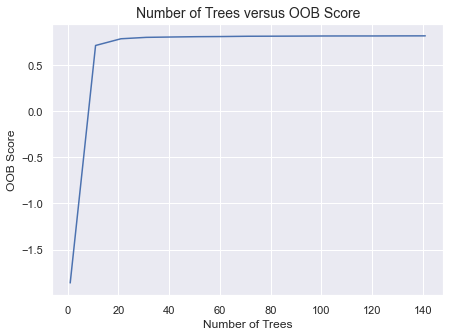

In [20]:
plt.figure(figsize=(7,5))
plt.plot(hyperparams, oobs)
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('OOB Score', fontsize=12)
plt.title('Number of Trees versus OOB Score', fontsize=14)
plt.show();

### Boosting

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

base = DecisionTreeRegressor(max_depth=10, random_state=5)
ada = AdaBoostRegressor(base_estimator=base, 
                       n_estimators=100,
                       learning_rate=1)
evaluate(ada)

Training RMSE: 0.303
Test RMSE: 0.506


In [39]:
gradient = GradientBoostingRegressor(n_estimators=150,
                                    loss='ls',
                                    learning_rate=0.1,
                                    subsample=0.6,
                                    max_features=None,
                                    max_depth=5)
evaluate(gradient)

Training RMSE: 0.378
Test RMSE: 0.492


In [40]:
bagdt = BaggingRegressor(base_estimator=gradient, 
                         n_estimators=100,
                         max_samples=0.7,
                         oob_score=True,
                         random_state=5, 
                         n_jobs=3)

evaluate(bagdt)

Training RMSE: 0.394
Test RMSE: 0.485


Running the code below with n_jobs=-1 caused "Insufficient system resources" error

In [ ]:
bagdt = BaggingRegressor(base_estimator=forest, 
                         n_estimators=100,
                         max_samples=0.7,
                         oob_score=True,
                         random_state=5, 
                         n_jobs=3)

evaluate(bagdt)